# 整体框架
![framework](./picture/framework.png)

环境 Environment:
- tensorflow ==1.14.0
- keras == 2.3.1
- numpy == 1.16.4
- matplotlib
- seaborn

In [1]:
import keras
from keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import DataPreProcess
import BuildModel
import TrainModel
import Visualization

Using TensorFlow backend.
/Users/zhenghu/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhenghu/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhenghu/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zhenghu/anaconda3/e

# Step1. 数据预处理
![dataset](./picture/dataset.png)

## 1. 导入数据

In [2]:
# 定义数据的位置
# 2013-11、2013-12是米兰市100*100网络中心的20*20的网络数据
# 2013-11-fusion、2013-12-fusion是将100*100网络聚合成20*20网络之后的数据

total_data_path = './data/total.vocab'
data_11 = './data/2013-11-fusion.vocab'
data_12 = './data/2013-12-fusion.vocab'
max_min_path = './data/loc_max_mix.vocab'

### ./data/2013-11.vocab 
米兰市2013年11月的基站流量数据，400\*30行，选取的城市网络是20\*20(聚合后)的规模，所以每400行数据代表11月一天内的数据流量，11月共有30天，所以一共400*30行,24列是指一天内的24个小时

./data/2013-12.vocab 和 ./data/2013-11.vocab形式一样

## 2. 处理零值
- 对数据进行填充缺失值的处理。每天不同时刻的流量值应该存在不同的规律，每周的工作日和周末的流量也有不同的模式，而且不同地区的流量可能存在不同的分布，所以在处理缺失值的时候应该考虑到这些情况。


- 目前使用的数据集不是原始的数据集，是经过了以下处理的数据集：由于原始数据（时间粒度为10分钟）中数据缺失地非常严重，所以做了以下处理：所有缺失值置为0。把时间粒度扩展到1小时，也就是把每天划分成24个时段，把该数据按照属性Time interval排序，然后取Call-in activity、Call-out activity在一个小时内的数据，统计它们各自有多少条非0数据，然后把两个属性非0数据各自加和求平均，然后处以各自非0的个数，得到两个均值。把均值相加再乘以6表示4041地区在11月1日该小时内的流量总和。经过上述处理后我们得到了新的时间粒度：1小时，以及新的流量值作为我们的基础数距（即每个时刻城市20 \* 20网络中每个小格中的流量值）。


- 可以看出，上述的处理主要是为了处理和标记原始数据集的缺失值，但是即便如此，数据集的缺失情况还是很严重，在新的数据集里，值为0的值很明显就是缺失值，将对新的数据集做以下缺失值处理：若某个流量值为0，假设它是地区0周一0时刻的流量值，取其之前后全部的地区0周一0时刻的非0值并计算它们的均值，然后该均值来填充该数据。

In [3]:
# 处理缺失值
data_without_missing_value = DataPreProcess.ProcessMissingValue(data_11, data_12, city_amount=400, judge_num=7)

(24000, 24)
There are 122 missing datas


## 3. 处理异常值
- 处理数据中的异常值，处理过程中考虑到的规律和处理缺失值时相同，接下来对每个地区每个时刻的流量值应用3西格玛准则来判断对应的异常值。


- 所以以地区0某一个周一0时刻的流量值为例，取其前后共8周的地区0周一0时刻的值计算均值和标准差，取其前后共30天在同一地区同一时刻的流量值计算均值和标准差，如果该流量值都不满足两组数据的3西格玛准则，则认定该流量值为异常流量值，用两组数据均值的均值来替换该数据。


- 以周数据为例，若前或后相同地区在同一时刻的值不足8个，则增加数据充足一侧的数据，比如地区0某一周一0时刻前只有1个对应的数据，则在该时刻后取7个数据

In [4]:
# 处理异常值
data_without_abnormal_value = DataPreProcess.ProcessAbnormalValue(data_without_missing_value, city_amount=400, judge_week_num=8, judge_day_num=30)

There are 3359 abnormal num


<a id='maxminsection'></a>
## 4. 归一化
对数据做归一化处理，采用的归一化方法是Max-Min法，即（value-min)/(max-min)，但是大部分地区预测出来结果不好，然后将归一化的值经过log1p()函数进行处理，最后的结果也不行，最后决定将400个地区每个小时的数据根据自己的最大最小值分别做Max-Min归一化，但是这么做在预测结果解归一化的时候非常难处理，所以我不在预测时解归一化，而是在恢复预测数据进行可视化的时候解归一化

In [5]:
# 数据归一化
total_data = DataPreProcess.DataNormalization(data_without_abnormal_value, max_min_path, city_amount=400)

(24000, 2)
(60, 400, 24)


- 开始制作训练集与测试集: 3\*20\*20\3\*20\*20\1\*20\*20

- 下面将制作能喂入模型的数据，把制作好的数据全部放入一个可读文件./data/total-fusion.vocab中 (24000,2)

In [6]:
# 数据保存
DataPreProcess.SavePreProcessData(total_data, total_data_path)

update ./data/total.vocab
success to save PreProcess data!


In [24]:
# %load DataPreProcess.py


## Step2. 模型定义、训练、保存


- 模型的整体结构：
![model structure](./picture/model.png)
<a id='deepstpaper'></a>
该模型来自于论文[DNN-Based Prediction Model for Spatio-Temporal Data](https://dl.acm.org/doi/abs/10.1145/2996913.2997016)中DeepST模型的一部分

In [7]:
# 超参数
OPTIMIZER = keras.optimizers.SGD(lr=0.01)
LOSS = 'mean_squared_error'
BATCH_SIZE = 64
EPOCHS = 20

# 设置输入数据的形式
closeness = layers.Input(shape=(20, 20, 3), name='closeness')
period = layers.Input(shape=(20, 20, 3), name='period')
trend = layers.Input(shape=(20, 20, 1), name='trend')
convlstmall = layers.Input(shape=(20,20, ),name='convlstmall') 


## 1. 模型定义

## `MiniDeepST`

在本案例中，由于缺少全局数据，故我们只考虑左半部分，即时空数据部分。模型结构非常简单，所包含的组件只有基本的卷积神经网络，我们将简化后的模型称为miniDeepST。![mini-DeepST](./picture/mini-DeepST.png)

假设我们要预测t时刻的城市流量分布，首先把城市分割成`m*n`的网格，每个时刻城市的流量分布状况可以用一个`m*n`的矩阵表示，把这个矩阵看成像素矩阵，那么我们就可以卷积神经网络来分析提取城市流量分布的特征。虽然卷积神经网络能很好地提取流量值在空间分布上的特征，但是无法分析城市流量在时间顺序上的特点，解决这个问题有很多方法，这里我们用多个并行的卷积层来简单地拟合数据在时间上的分布。

由上图可以看出，有3个并行卷积层t、p、s。其中卷积层t的输入数据是时刻t前3个连续时刻的城市流量数据组成的3通道像素矩阵，代表着邻近时间数据的相似性；卷积层p的输入数据是距时刻t所在天数前三天中相同时刻的城市流量数据组成的3通道像素矩阵，代表数据在时间上的周期性；卷积层s的输入数据是时刻t所在周前一周同一时刻的城市流量数据组成的单通道像素矩阵，代表数据在时间上的趋势。

所谓聚合，简单来说就是把卷积层t、p、s的计算结果加权相加然后再通过一个卷积层。聚合层的输出再经过两个卷积层的计算后，把最终计算结果拉平成长度为m*n的向量，结果保存成向量的格式是因为在程序实现的过程中，我们通常要一次对一组结果（结果的个数为batch_size）计算损失函数的值，结果保存成一维向量有利于程序代码的编写。为了加快梯度下降最优质的求解速度以及提高模型准确度，所有的输入数据都做了归一化处理（这里采用了简单的[Max-Min归一化）](#maxminsection)，所以输出也必须保证在[0,1]之间，所以最后的卷积层2采用的激活函数为sigmoid函数，其余卷积层的激活函数为Relu函数（采用Relu作为卷积层的激活函数的原因可以参考论文[Image Net Classiﬁcation with Deep Convolutional Neural Networks](https://dl.acm.org/doi/abs/10.1145/3065386)。模型的更多细节请参考[原论文](#deepstpaper)。

In [8]:
# mini-DeepST模型构建
MiniDeepST_output = BuildModel.MiniDeepST(closeness, period, trend, filters=64, kernel_size=(3,3), activation='relu', use_bias=True)
MiniDeepST = Model(inputs=[closeness, period, trend], outputs=MiniDeepST_output)
MiniDeepST.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)
# 去掉注释可以显示整个模型结构
MiniDeepST.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
period (InputLayer)             (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
trend (InputLayer)              (None, 20, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 20, 20, 64)   1792        closeness[0][0]                  
____________________________________________________________________________________________

## `+ ResNet`
残差网络（[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)）在图像领域已然成为了一种主流模型。残差网络是为了解决深度神经网络（DNN）隐藏层过多时的网络退化问题而提出。这里的退化问题是指：当网络隐藏层变多时，网络的准确度达到饱和然后急剧退化，而且这个退化不是由于过拟合引起的。

如果在流量预测任务中，仅使用miniDeepST性能还不足以另我们满意，可以考虑在miniDeepST的基础上加上[残差块](#resunit)，因为其对网络退化问题的解决，可能对最后性能产生改进影响。残差单元可以以跳层连接的形式实现，即将单元的输入直接与单元输出加在一起，然后再激活。因此残差网络可以轻松地用主流的自动微分深度学习框架实现，直接使用BP算法更新参数。在前向传播时，输入信号可以从任意低层直接传播到高层。由于包含了一个天然的恒等映射，一定程度上可以解决网络退化问题。
![mini-ST-ResNet](./picture/mini-ST-ResNet.png)


<a id='resunit'></a>
### 残差块 ResUnit
![ResNet-Unit](./picture/resnet.png)

In [9]:
MiniSTResNet_output = BuildModel.MiniSTResNet(closeness, period, trend, filters=64, kernel_size=(3,3), activation='relu', use_bias=True)
MiniSTResNet = Model(inputs=[closeness, period, trend], outputs=MiniSTResNet_output)
MiniSTResNet.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)
# 去掉注释可以显示整个模型结构
MiniSTResNet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
period (InputLayer)             (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
trend (InputLayer)              (None, 20, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 20, 20, 64)   1792        closeness[0][0]                  
____________________________________________________________________________________________

## + `ConvLSTM`
在论文[Long-Term Mobile Traffic Forecasting Using Deep Spatio-Temporal Neural Networks](https://dl.acm.org/doi/abs/10.1145/3209582.3209606)中，作者使用卷积LSTM和3D卷积联合实现长期流量的预测。

ConvLSTM，由施行健提出，发表在[NIPS 2015](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)。其核心本质还是和LSTM一样，将上一层的输出作为下一层的输入。不同的地方在于ConvLSTM加入了卷积操作之后，不仅能够得到时序关系，还能够像卷积层一样提取空间特征，这样ConvLSTM就可以同时提取时间特征和空间特征（时空特征），并且状态与状态之间的切换也换成了卷积运算。
![convLSTM](./picture/ConvLSTMforprecipitation.png)

3D卷积，顾名思义，卷积核核在3个维度上滑动，从使用其核从3D数据中提取3D的空间特征。--其中一维可看成时间维。[Conv3D论文](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf)
![Conv3D](./picture/conv3D.jpg)


在miniSTResNet模型上,刻意引入了convLSTM（不鼓励这种做法，bad example）![目前工具箱上接上convLSTM的尝试](./picture/STConvLSTM.png)


In [10]:
ConvLSTM_output = BuildModel.ConvLSTM(closeness, period, trend)
ConvLSTM = Model(inputs=[closeness, period, trend], outputs=ConvLSTM_output)
ConvLSTM.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=None)
# 去掉注释可以显示整个模型结构
ConvLSTM.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
closeness (InputLayer)          (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
period (InputLayer)             (None, 20, 20, 3)    0                                            
__________________________________________________________________________________________________
trend (InputLayer)              (None, 20, 20, 1)    0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 20, 20, 64)   1792        closeness[0][0]                  
____________________________________________________________________________________________

In [ ]:
# %load BuildModel.py


## 2. 模型训练和预测

## 数据集制作

In [11]:
# 获取预处理后的数据
total_data_path = './data/total.vocab'
train_data, test_data = TrainModel.MakeDataset(total_data_path)

# 获取训练数据
c_train = train_data[:, :, :, 0:3]
p_train = train_data[:, :, :, 3:6]
t_train = train_data[:, :, :, 6:7]
train_label = train_data[:, :, :, -1]
train_label = np.reshape(train_label, [train_data.shape[0], 400])

# 获取测试的数据
c_test = test_data[:, :, :, 0:3]
p_test = test_data[:, :, :, 3:6]
t_test = test_data[:, :, :, 6:7]
test_label = test_data[:, :, :, -1]
test_label = np.reshape(test_label, [test_data.shape[0], 400])
STEPS_PER_EPOCH = int(train_data.shape[0] // BATCH_SIZE)

(60, 400, 24)


## MiniDeepST

In [12]:
# 训练和保存模型
print('-> Start to train MiniDeepST model!')
MiniDeepST_history = MiniDeepST.fit_generator(generator=TrainModel.Generator([c_train, p_train, t_train], train_label,  STEPS_PER_EPOCH, BATCH_SIZE),steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, shuffle=True)
MiniDeepST_path = './model/MiniDeepST.h5'
MiniDeepST.save_weights(MiniDeepST_path)
print('-> Finish to save MiniDeepST model')

# 保存预测数据
MiniDeepST_result_path = './data/MiniDeepST_result.vocab'
MiniDeepST_predict = MiniDeepST.predict([c_test, p_test, t_test], batch_size=BATCH_SIZE ,verbose=1)
print(MiniDeepST_predict.shape)
TrainModel.WriteData(MiniDeepST_result_path, MiniDeepST_predict)

-> Start to train MiniDeepST model!

Epoch 1/20
15/15 [==============================] - 6s 394ms/step - loss: 0.1649
Epoch 2/20
15/15 [==============================] - 5s 324ms/step - loss: 0.0666
Epoch 3/20
15/15 [==============================] - 4s 281ms/step - loss: 0.0337
Epoch 4/20
15/15 [==============================] - 4s 268ms/step - loss: 0.0293
Epoch 5/20
15/15 [==============================] - 4s 280ms/step - loss: 0.0267
Epoch 6/20
15/15 [==============================] - 4s 280ms/step - loss: 0.0249
Epoch 7/20
15/15 [==============================] - 4s 279ms/step - loss: 0.0236
Epoch 8/20
15/15 [==============================] - 4s 295ms/step - loss: 0.0225
Epoch 9/20
15/15 [==============================] - 5s 313ms/step - loss: 0.0216
Epoch 10/20
15/15 [==============================] - 5s 311ms/step - loss: 0.0208
Epoch 11/20
15/15 [==============================] - 4s 287ms/step - loss: 0.0201
Epoch 12/20
15/15 [==============================] - 5s 300ms/step - l

## MiniSTResNet

In [13]:
# 训练和保存模型
print('-> Start to train MiniSTResNet model!')
MiniSTResNet_history = MiniSTResNet.fit_generator(generator=TrainModel.Generator([c_train, p_train, t_train], train_label,  STEPS_PER_EPOCH, BATCH_SIZE),steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, shuffle=True)
MiniSTResNet_path = './model/MiniSTResNet.h5'
MiniSTResNet.save_weights(MiniSTResNet_path)
print('-> Finish to save MiniSTResNet model')

# 保存预测数据
MiniSTResNet_result_path = './data/MiniSTResNet_result.vocab'
MiniSTResNet_predict = MiniSTResNet.predict([c_test, p_test, t_test], batch_size=BATCH_SIZE ,verbose=1)
TrainModel.WriteData(MiniSTResNet_result_path, MiniSTResNet_predict)

-> Start to train MiniSTResNet model!
Epoch 1/20
15/15 [==============================] - 8s 516ms/step - loss: 0.0357
Epoch 2/20
15/15 [==============================] - 5s 353ms/step - loss: 0.0183
Epoch 3/20
15/15 [==============================] - 5s 358ms/step - loss: 0.0146
Epoch 4/20
15/15 [==============================] - 5s 350ms/step - loss: 0.0123
Epoch 5/20
15/15 [==============================] - 5s 360ms/step - loss: 0.0109
Epoch 6/20
15/15 [==============================] - 5s 357ms/step - loss: 0.0099
Epoch 7/20
15/15 [==============================] - 6s 412ms/step - loss: 0.0092
Epoch 8/20
15/15 [==============================] - 5s 352ms/step - loss: 0.0086
Epoch 9/20
15/15 [==============================] - 5s 351ms/step - loss: 0.0082
Epoch 10/20
15/15 [==============================] - 5s 361ms/step - loss: 0.0078
Epoch 11/20
15/15 [==============================] - 5s 353ms/step - loss: 0.0075
Epoch 12/20
15/15 [==============================] - 6s 377ms/step - 

## ConvLSTM

In [14]:
# 训练和保存模型
print('-> Start to train ConvLSTM model!')
ConvLSTM_history = ConvLSTM.fit_generator(generator=TrainModel.Generator([c_train, p_train, t_train], train_label,  STEPS_PER_EPOCH, BATCH_SIZE),steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1, shuffle=True)
ConvLSTM_path = './model/ConvLSTM.h5'
ConvLSTM.save_weights(ConvLSTM_path)
print('-> Finish to save ConvLSTM model')

# 保存预测数据
ConvLSTM_result_path = './data/ConvLSTM_result.vocab'
ConvLSTM_predict = ConvLSTM.predict([c_test, p_test, t_test], batch_size=BATCH_SIZE ,verbose=1)
TrainModel.WriteData(ConvLSTM_result_path, ConvLSTM_predict)

-> Start to train ConvLSTM model!
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
15/15 [==============================] - 35s 2s/step - loss: 0.0309
Epoch 2/20
15/15 [==============================] - 30s 2s/step - loss: 0.0187
Epoch 3/20
15/15 [==============================] - 32s 2s/step - loss: 0.0160
Epoch 4/20
15/15 [==============================] - 31s 2s/step - loss: 0.0141
Epoch 5/20
15/15 [==============================] - 31s 2s/step - loss: 0.0127
Epoch 6/20
15/15 [==============================] - 31s 2s/step - loss: 0.0116
Epoch 7/20
15/15 [==============================] - 31s 2s/step - loss: 0.0107
Epoch 8/20
15/15 [==============================] - 30s 2s/step - loss: 0.0100
Epoch 9/20
15/15 [==============================] - 30s 2s/step - loss: 0.0094
Epoch 10/20
15/15 [==============================] - 31s 2s/step - loss: 0.0089
Epoch 11/20
15/15 [==============================] - 30s 2s/step - loss: 0.0085
E

In [15]:
# 保存预测的真实值
labels = test_label
labels_savepath = './data/labels.vocab'
TrainModel.WriteData(labels_savepath, labels)

Finish to save data!


In [ ]:
# %load TrainModel.py

# Step3 可视化
![visulization](./picture/visualization.png)

## Loss可视化

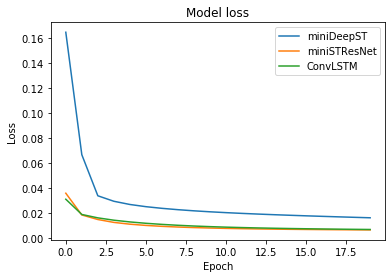

In [16]:
# 显示训练Loss
plt.plot(MiniDeepST_history.history['loss'], label='miniDeepST')
plt.plot(MiniSTResNet_history.history['loss'], label='miniSTResNet')
plt.plot(ConvLSTM_history.history['loss'], label='ConvLSTM')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 结果可视化

## 获取预测结果

In [17]:
# 获取预测数据并归一化
MiniDeepST_result_path = './data/MiniDeepST_result.vocab'
MiniSTResNet_result_path = './data/MiniSTResNet_result.vocab'
ConvLSTM_result_path = './data/ConvLSTM_result.vocab'
max_min_path = './data/loc_max_mix.vocab'
label_path = './data/labels.vocab'

MiniDeepST_result = Visualization.DecodeData(MiniDeepST_result_path, max_min_path)
MiniSTResNet_result = Visualization.DecodeData(MiniSTResNet_result_path, max_min_path)
ConvLSTM_result = Visualization.DecodeData(ConvLSTM_result_path, max_min_path)
label = Visualization.DecodeData(label_path, max_min_path) 

# 构建预测结果字典
results_dict = {'MiniDeepST':MiniDeepST_result, 'MiniSTResNet': MiniSTResNet_result,'MiniSTRConvLSTM':ConvLSTM_result}

In [18]:
# MiniDeepST 性能评估
MiniDeepST_MAE = Visualization.CalculateMAE(MiniDeepST_result, label)
MiniDeepST_RMSE = Visualization.CalculateRMSE(MiniDeepST_result, label)
MiniDeepST_R2_score = Visualization.CalculateR2score(MiniDeepST_result, label)

# MiniSTResNet 性能评估
MiniSTResNet_MAE = Visualization.CalculateMAE(MiniSTResNet_result, label)
MiniSTResNet_RMSE = Visualization.CalculateRMSE(MiniSTResNet_result, label)
MiniSTResNet_R2_score = Visualization.CalculateR2score(MiniSTResNet_result, label)


# ConvLSTM 性能评估
ConvLSTM_MAE = Visualization.CalculateMAE(ConvLSTM_result, label)
ConvLSTM_RMSE = Visualization.CalculateRMSE(ConvLSTM_result, label)
ConvLSTM_R2_score = Visualization.CalculateR2score(ConvLSTM_result, label)


print('MiniDeepST   -> MAE: %f.  RMSE: %f.  R2_score: %f.' % (MiniDeepST_MAE, MiniDeepST_RMSE, MiniDeepST_R2_score))
print('MiniSTResNet -> MAE: %f.  RMSE: %f.  R2_score: %f.' % (MiniSTResNet_MAE, MiniSTResNet_RMSE, MiniSTResNet_R2_score))
print('ConvLSTM     -> MAE: %f.  RMSE: %f.  R2_score: %f.' % (ConvLSTM_MAE, ConvLSTM_RMSE, ConvLSTM_R2_score))

MiniDeepST   -> MAE: 144.013917.  RMSE: 232.167954.  R2_score: 0.700063.
MiniSTResNet -> MAE: 101.217911.  RMSE: 166.418106.  R2_score: 0.810864.
ConvLSTM     -> MAE: 100.537848.  RMSE: 165.158165.  R2_score: 0.821530.


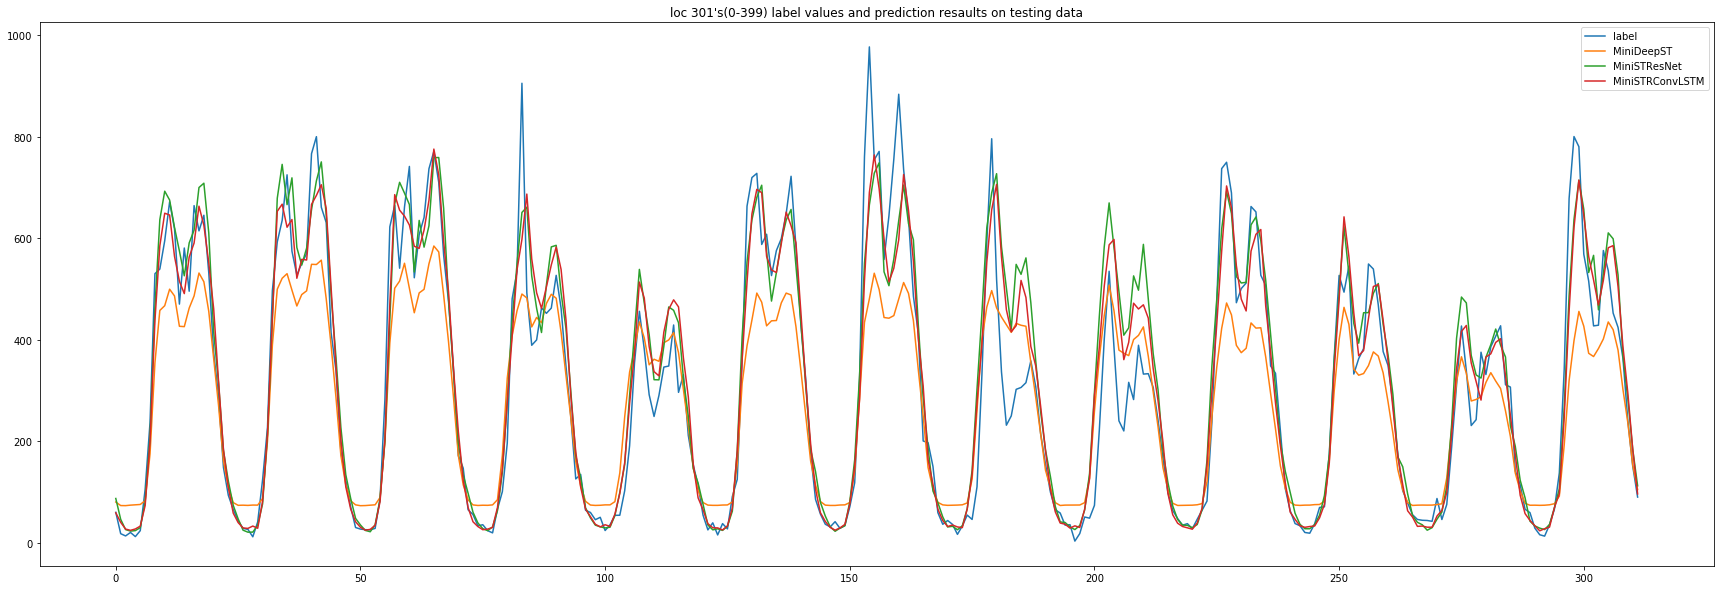

In [19]:
# 显示预测某区域的预测曲线和真实曲线
loc_id = 301
Visualization.ShowPrediction(loc_id, results_dict, label)

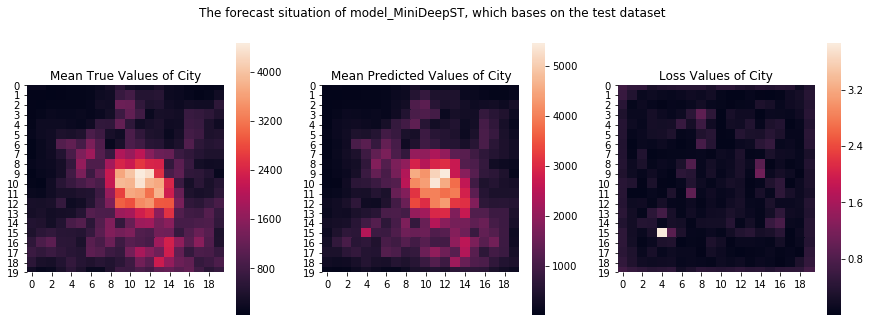

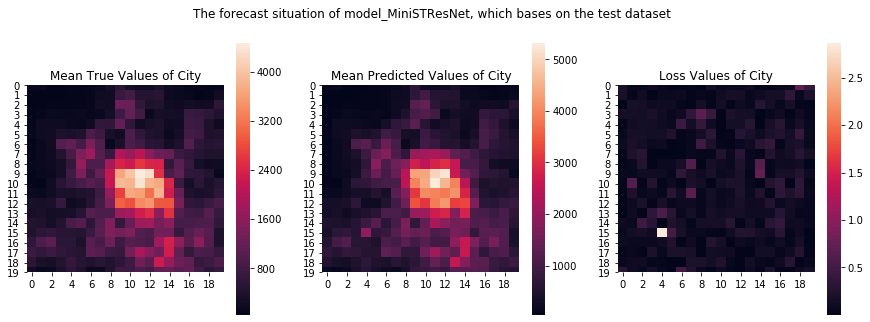

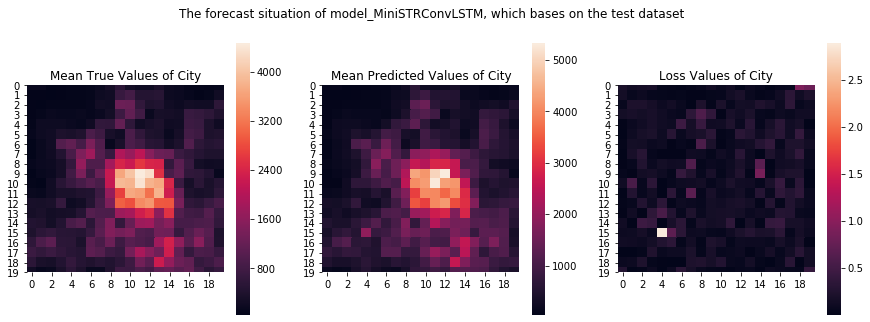

In [20]:
# 显示热力图
hour = 12
Visualization.HotMap(hour, results_dict, label)

In [ ]:
# %load Visualization.py